In [1]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from utils.dataset import ChestImage64
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader

In [2]:
csv_path = './Data/256px Images/train_labels_256p.csv'
root_path = './Data/256px Images'

In [3]:
transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
dataset = ChestImage64(csv_path=csv_path, root_path=root_path, class_name="Frontal", transform=transform)

In [19]:
train_size = round(0.7 * len(dataset))
val_size = round(0.1 * len(dataset))
test_size = round(0.2 * len(dataset))

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


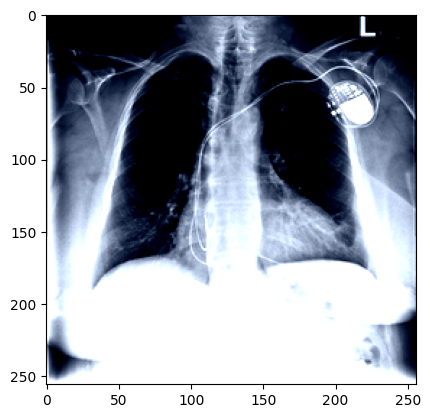

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


In [20]:
for item in train_loader:
    image = item[0][0].numpy()/2 + 0.5
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.show()
    print(item[1][0])
    break

In [22]:
## define the data
from model.ViT import ViT
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from utils.dataset import ChestImage64
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader
from torch import optim
import torch.nn.functional as F
import time

model = ViT(image_size=256, patch_size=8, num_classes=14, channels=3, dim=128, depth=12, heads=12, mlp_dim=128)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

criterion = torch.nn.BCEWithLogitsLoss()

# %%
def train_epoch(model, optimizer, data_loader, loss_history, device):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output,target)

        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' + '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:3' if use_cuda else 'cpu')

N_EPOCHS = 7

start_time = time.time()

model.to(device)

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history, device)
    # evaluate(model, test_loader, test_loss_history, device)

Epoch: 1
[    0/21441 (  0%)]  Loss: 0.7931
[ 3200/21441 ( 15%)]  Loss: 0.5339
[ 6400/21441 ( 30%)]  Loss: 0.5959
[ 9600/21441 ( 45%)]  Loss: 0.5910
[12800/21441 ( 60%)]  Loss: 0.5209
[16000/21441 ( 75%)]  Loss: 0.5628
[19200/21441 ( 89%)]  Loss: 0.4828
Epoch: 2
[    0/21441 (  0%)]  Loss: 0.5636
[ 3200/21441 ( 15%)]  Loss: 0.4788
[ 6400/21441 ( 30%)]  Loss: 0.5005
[ 9600/21441 ( 45%)]  Loss: 0.5153
[12800/21441 ( 60%)]  Loss: 0.5188
[16000/21441 ( 75%)]  Loss: 0.5251
[19200/21441 ( 89%)]  Loss: 0.4641
Epoch: 3
[    0/21441 (  0%)]  Loss: 0.5552
[ 3200/21441 ( 15%)]  Loss: 0.5331
[ 6400/21441 ( 30%)]  Loss: 0.4542
[ 9600/21441 ( 45%)]  Loss: 0.4408
[12800/21441 ( 60%)]  Loss: 0.5528
[16000/21441 ( 75%)]  Loss: 0.5402
[19200/21441 ( 89%)]  Loss: 0.4845
Epoch: 4
[    0/21441 (  0%)]  Loss: 0.5052
[ 3200/21441 ( 15%)]  Loss: 0.5300
[ 6400/21441 ( 30%)]  Loss: 0.5511
[ 9600/21441 ( 45%)]  Loss: 0.4732
[12800/21441 ( 60%)]  Loss: 0.4283
[16000/21441 ( 75%)]  Loss: 0.4582
[19200/21441 ( 89%)

In [23]:
def multi_class_multi_label_accuracy(y_pred, y_true, threshold=0.5):
    # Apply sigmoid function to raw outputs
    y_pred = torch.sigmoid(y_pred)

    # Threshold the predictions
    y_pred = (y_pred > threshold).float()
    # Compute accuracy
    correct = (y_pred == y_true).float()
    accuracy = correct.sum() / (y_true.numel())

    return accuracy


In [39]:
# Import torch and the accuracy function
import torch
total_accuracy  = []
for test_data, target in test_loader:
    # Compute multi-class multi-label accuracy
    test_data = test_data.to(device)
    target = target.to(device)
    model.to(device)
    y_pred = model(test_data)
    accuracy = multi_class_multi_label_accuracy(y_pred, target, threshold=0.5)
    total_accuracy.append(accuracy.item())

print("Accuracy: {:.2f}".format((np.mean(total_accuracy))))


ValueError: only one element tensors can be converted to Python scalars

In [25]:
sum(p.numel() for p in model.parameters())


5281294

In [27]:
!pip install torchsummary

In [36]:
from torchsummary import summary
model.to('cuda:0')
summary(model, input_size=(3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1            [-1, 1024, 192]               0
         LayerNorm-2            [-1, 1024, 192]             384
            Linear-3            [-1, 1024, 128]          24,704
         LayerNorm-4            [-1, 1024, 128]             256
           Dropout-5            [-1, 1025, 128]               0
         LayerNorm-6            [-1, 1025, 128]             256
            Linear-7           [-1, 1025, 2304]         294,912
           Softmax-8       [-1, 12, 1025, 1025]               0
           Dropout-9       [-1, 12, 1025, 1025]               0
           Linear-10            [-1, 1025, 128]          98,432
          Dropout-11            [-1, 1025, 128]               0
        Attention-12            [-1, 1025, 128]               0
          PreNorm-13            [-1, 1025, 128]               0
        LayerNorm-14            [-1, 10

In [43]:
import torch

# Sample tensors representing model outputs (logits) and true labels
y_pred_all = torch.tensor([[1.0, 1.5, 0.8], [2.2, -0.4, 1.1]])
y_true_all = torch.tensor([[0, 1, 1], [1, 0, 1]])

# Move tensors to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_pred_all = y_pred_all.to(device)
y_true_all = y_true_all.to(device)

# Initialize a tensor to store the class-wise correct predictions
class_correct = torch.zeros(y_true_all.shape[1], device=device)
class_total = torch.zeros(y_true_all.shape[1], device=device)

# Apply sigmoid function to raw outputs
y_pred = torch.sigmoid(y_pred_all)

# Threshold the predictions
y_pred = (y_pred > 0.5).float()

# Compute class-wise correct predictions and total predictions
correct = (y_pred == y_true_all).float()
class_correct += correct.sum(dim=0)
class_total += y_true_all.size(0)

# Calculate the class-wise accuracies
class_accuracies = class_correct / class_total

# Print the class-wise accuracies
for i, class_accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {i}: {class_accuracy:.2f}")

# Calculate the average accuracy across all classes
average_accuracy = class_accuracies.mean()
print(f"Average accuracy: {average_accuracy:.2f}")


Accuracy for class 0: 0.50
Accuracy for class 1: 1.00
Accuracy for class 2: 1.00
Average accuracy: 0.83


In [45]:
import torch

# Define your model and load the state_dict if needed
# model.load_state_dict(torch.load("path/to/your/model_weights.pth"))

# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Initialize a tensor to store the class-wise correct predictions and total predictions
num_classes = 14  # Set the number of classes in your problem
class_correct = torch.zeros(num_classes, device=device)
class_total = torch.zeros(num_classes, device=device)

# Iterate over the test dataset using the test_loader
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Apply sigmoid function to raw outputs
        y_pred = torch.sigmoid(outputs)

        # Threshold the predictions
        y_pred = (y_pred > 0.5).float()

        # Compute class-wise correct predictions and total predictions
        correct = (y_pred == labels).float()
        class_correct += correct.sum(dim=0)
        class_total += labels.size(0)
        
# Calculate the class-wise accuracies
class_accuracies = class_correct / class_total

# Print the class-wise accuracies
for i, class_accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {i}: {class_accuracy:.2f}")

# Calculate the average accuracy across all classes
average_accuracy = class_accuracies.mean()
print(f"{average_accuracy:.2f}")


Accuracy for class 0: 0.74
Accuracy for class 1: 0.75
Accuracy for class 2: 0.75
Accuracy for class 3: 0.89
Accuracy for class 4: 0.83
Accuracy for class 5: 0.77
Accuracy for class 6: 0.76
Accuracy for class 7: 0.76
Accuracy for class 8: 0.92
Accuracy for class 9: 0.76
Accuracy for class 10: 0.74
Accuracy for class 11: 0.65
Accuracy for class 12: 0.68
Accuracy for class 13: 0.72
Average accuracy: 0.77


In [46]:
for i, class_accuracy in enumerate(class_accuracies):
    print(f"{class_accuracy:.2f}")


0.74
0.75
0.75
0.89
0.83
0.77
0.76
0.76
0.92
0.76
0.74
0.65
0.68
0.72
